In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

Activating environment at `~/Projects/IntrinsicVariability/Project.toml`


In [2]:
using DifferentialEquations, PyPlot, DSP, Statistics

# Intrinsic variability in Lorenz 63

Let's solve Lorenz 63:

$$ \dot x = \alpha (y - x) $$
$$ \dot y = - xz + \beta x - y $$
$$ \dot z = x y - \gamma z $$

Notice that 

$$\dot y = - xz - \beta \left ( y - x \right ) + \left ( \beta - 1 \right ) y $$

and

$$\frac{\mathrm{d}}{\mathrm{d} t} (x - y) = - \left ( \alpha + \beta \right ) (x - y) + xz - \left ( \beta - 1 \right ) y$$

In other words, the difference $x-y$ is strongly damped to zero. As a result, the dynamics of $z$ are uninteresting, because $xy$ is often small and $\gamma$ ensures that $z$ does not get too big.

Everyone chooses $(\alpha, \beta, \gamma) = (10, 28, 8/3)$, but I have no idea why. Playing around with numbers suggests that $\beta$ needs to be larger than $\alpha$ for anything interesting to happen, and also $\gamma$ cannot be too big (or $z$ just damps to zero boringly). Anyways, we code up the classical system using $u = (x, y, z)$ below.

In [3]:
α = 10
β = 28
γ = 8/3

function lorenz63!(du, u, p, t)
    du[1] = α * (u[2] - u[1])
    du[2] = u[1] * (β - u[3]) - u[2]
    du[3] = u[1] * u[2] - γ * u[3]
    return nothing
end

function extract(solution)
    x = map(u -> u[1], solution.u)
    y = map(u -> u[2], solution.u)
    z = map(u -> u[3], solution.u)
    return x, y, z, solution.t
end

extract (generic function with 1 method)

Next we solve this with the initial condition

$$ x = 1, \qquad \text{and} \qquad y = z = 0 $$

on $t \in [0, 10000]$.

In [4]:
uᵢ = [1.0; 0.0; 0.0]
time_span = (0.0, 10000.0)
problem = ODEProblem(lorenz63!, uᵢ, time_span)
solution = solve(problem);

The solution looks legit:

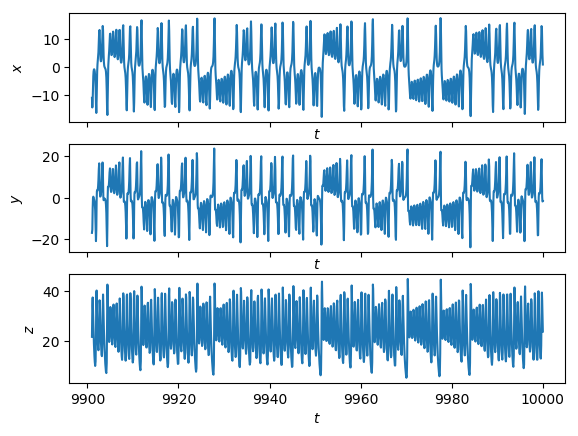

mean(x) = 0.10035046002665542
mean(y) = 0.09973675030906547
mean(z) = 23.943787885677093


In [5]:
function plot_solution(solution; fraction=100)
    x, y, z, t = extract(solution)

    @show mean(x) mean(y) mean(z)

    fig, axs = subplots(nrows=3, sharex=true)

    i = length(t)-round(Int, length(t)/fraction):length(t)

    sca(axs[1])
    plot(t[i], x[i])
    xlabel(L"t")
    ylabel(L"x")

    sca(axs[2])
    plot(t[i], y[i])
    xlabel(L"t")
    ylabel(L"y")

    sca(axs[3])
    plot(t[i], z[i])
    xlabel(L"t")
    ylabel(L"z")
    
    return nothing 
end

plot_solution(solution)

To visualize intrinsic variability, we plot a periodogram (which omits the 0-frequency contiribution) constructed by averaging spectra on half-overlapping intervals (the 'Welch' method):

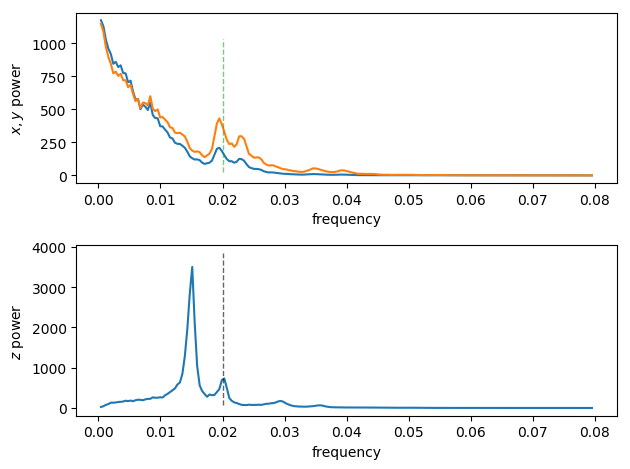

In [32]:
function plot_spectra(solution; samples=400, special_xy_frequency=nothing, special_z_frequency=nothing)
    x, y, z = extract(solution)

    x_spectrum = welch_pgram(x, samples)
    y_spectrum = welch_pgram(y, samples)
    z_spectrum = welch_pgram(z, samples)

    fig, axs = subplots(nrows=2)

    sca(axs[1])

    plot(x_spectrum.freq[2:end] / 2π, x_spectrum.power[2:end])
    plot(y_spectrum.freq[2:end] / 2π, y_spectrum.power[2:end])
    
    if special_xy_frequency != nothing
        plot(special_xy_frequency * [1, 1], [0.02, 0.9] * maximum(y_spectrum.power), 
             "--", linewidth=1, alpha=0.6)
    end

    xlabel("frequency")
    ylabel("\$ x, y \$ power")

    sca(axs[2])
    plot(z_spectrum.freq[2:end] / 2π, z_spectrum.power[2:end])
    
    if special_z_frequency != nothing
        plot(special_z_frequency * [1, 1], [0.02, 1.1] * maximum(z_spectrum.power[2:end]), 
             "k--", linewidth=1, alpha=0.6)
    end

    xlabel("frequency")
    ylabel("\$ z \$ power")

    tight_layout()
    
    return nothing
end

plot_spectra(solution, special_xy_frequency=0.02, special_z_frequency=0.02)

# Periodically forced Lorenz

Let's try

In [80]:
x, y, z, t = extract(solution)

ω = 0.05
a = 1.0

function forced_lorenz63!(du, u, p, t)
    du[1] = α * (u[2] - u[1]) 
    du[2] = u[1] * (β - u[3]) - u[2] 
    du[3] = u[1] * u[2] - γ * u[3] + a / ω * cos(ω * t)
    return nothing
end

forced_problem = ODEProblem(forced_lorenz63!, uᵢ, (0, 100000.0))
forced_solution = solve(forced_problem);

┌ Warning: Interrupted. Larger maxiters is needed.
└ @ DiffEqBase /Users/gregorywagner/.julia/packages/DiffEqBase/Oc5M9/src/integrator_interface.jl:329


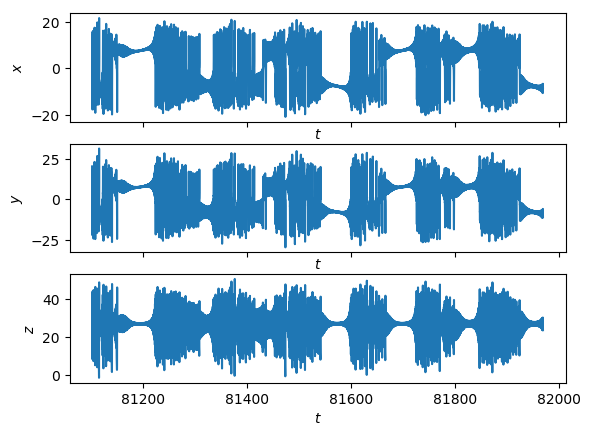

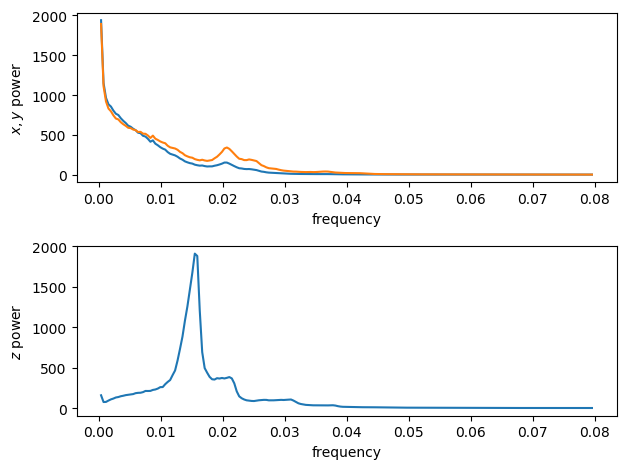

mean(x) = 0.11435666796598672
mean(y) = 0.11251372264060756
mean(z) = 24.437948765916033


In [81]:
plot_solution(forced_solution)
plot_spectra(forced_solution)